In [39]:
# 1) Load required libraries and dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn whitegrid style (replacement for theme_bw)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlelocation'] = 'center'

# Load dataset
data = pd.read_csv('QVI_data.csv')
data['DATE'] = pd.to_datetime(data['DATE'])

print("Rows, columns:", data.shape)
print("Columns:", data.columns)
data.head()


Rows, columns: (264834, 12)
Columns: Index(['LYLTY_CARD_NBR', 'DATE', 'STORE_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'PACK_SIZE', 'BRAND', 'LIFESTAGE',
       'PREMIUM_CUSTOMER'],
      dtype='object')


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [40]:
# 2) Create YEARMONTH and measureOverTime
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

measureOverTime = (
    data
    .groupby(['STORE_NBR','YEARMONTH'], observed=True)
    .agg(
        totSales = ('TOT_SALES','sum'),
        nCustomers = ('LYLTY_CARD_NBR', pd.Series.nunique),
        nTxns = ('TXN_ID', pd.Series.nunique),
        totalChips = ('PROD_QTY', 'sum')
    )
    .reset_index()
)

# compute derived metrics
measureOverTime['nTxnPerCust'] = measureOverTime['nTxns'] / measureOverTime['nCustomers']
measureOverTime['nChipsPerTxn'] = measureOverTime['totalChips'] / measureOverTime['nTxns']
measureOverTime['avgPricePerUnit'] = measureOverTime['totSales'] / measureOverTime['totalChips']

# quick check
print("measureOverTime rows:", measureOverTime.shape[0])
display(measureOverTime.head())


measureOverTime rows: 3169


,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxns,totalChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,201810,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,201811,192.6,46,47,57,1.021739,1.212766,3.378947


In [41]:
# 3) Identify stores that are present for the whole pre-trial period
# R used YEARMONTH < 201902 as "pre-trial" and then required N == 12.
pretrial_cutoff = 201902    # months strictly less than this are pre-trial
required_months = 7        # set to 12 to mirror R; change to 8 if your data has 8-month pre-trial

counts = (
    measureOverTime[measureOverTime['YEARMONTH'] < pretrial_cutoff]
    .groupby('STORE_NBR', observed=True)['YEARMONTH']
    .nunique()
    .reset_index(name='n_months')
)

storesWithFullObs = counts.loc[counts['n_months'] == required_months, 'STORE_NBR'].tolist()
print(f"Stores with full pre-trial observation (N == {required_months}): {len(storesWithFullObs)} stores")
# optionally inspect a few
display(counts.sort_values('n_months', ascending=False))


Stores with full pre-trial observation (N == 7): 260 stores


,STORE_NBR,n_months
270,272,7
0,1,7
1,2,7
2,3,7
3,4,7
...,...,...
209,211,1
75,76,1
84,85,1
204,206,1


In [42]:
required_months = counts['n_months'].max()
print("Detected pre-trial months =", required_months)


Detected pre-trial months = 7


In [43]:
# 4) Subset the measure table to pre-trial months and stores with full observation
preTrialMeasures = measureOverTime[
    (measureOverTime['YEARMONTH'] < pretrial_cutoff) &
    (measureOverTime['STORE_NBR'].isin(storesWithFullObs))
].copy()

print("preTrialMeasures rows:", preTrialMeasures.shape[0])
display(preTrialMeasures.head())


preTrialMeasures rows: 1820


,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxns,totalChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,201810,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,201811,192.6,46,47,57,1.021739,1.212766,3.378947


In [44]:
# 5) Correlation function (returns DataFrame Store1, Store2, corr_measure)
def calculate_correlation(input_df, metric_col, store_comparison, min_overlap=3):
    # pivot to wide: rows=YEARMONTH, cols=STORE_NBR
    pivot = input_df.pivot(index='YEARMONTH', columns='STORE_NBR', values=metric_col)
    stores = pivot.columns.tolist()
    rows = []
    for s in stores:
        if s == store_comparison:
            # auto-correlation = 1, but keep it for completeness
            rows.append({'Store1': store_comparison, 'Store2': s, 'corr_measure': 1.0})
            continue
        # align on months present for both
        x = pivot[store_comparison]
        y = pivot[s]
        common_idx = x.dropna().index.intersection(y.dropna().index)
        if len(common_idx) >= min_overlap:
            corr = x.loc[common_idx].corr(y.loc[common_idx])
        else:
            corr = np.nan
        rows.append({'Store1': store_comparison, 'Store2': s, 'corr_measure': corr})
    return pd.DataFrame(rows)


In [45]:
# 6) Magnitude distance function (returns average mag_measure per Store1-Store2)
def calculate_magnitude_distance(input_df, metric_col, store_comparison):
    # pivot wide
    pivot = input_df.pivot(index='YEARMONTH', columns='STORE_NBR', values=metric_col)
    stores = pivot.columns.tolist()
    rows = []
    # build a long table of abs differences per YEARMONTH
    dist_records = []
    for s in stores:
        # absolute difference per YEARMONTH between store_comparison and s
        diff = (pivot[store_comparison] - pivot[s]).abs()
        for ym, measure in diff.items():
            dist_records.append({'Store1': store_comparison, 'Store2': s, 'YEARMONTH': ym, 'measure': measure})
    dist_df = pd.DataFrame(dist_records)
    # compute min/max per Store1 & YEARMONTH to standardize
    minmax = dist_df.groupby(['Store1','YEARMONTH'])['measure'].agg(['min','max']).reset_index().rename(columns={'min':'minDist','max':'maxDist'})
    dist_df = dist_df.merge(minmax, on=['Store1','YEARMONTH'], how='left')
    # standardize to [0,1], handle zero division: if max==min then give 1.0 (perfect match)
    dist_df['magnitudeMeasure'] = np.where(
        dist_df['maxDist'] - dist_df['minDist'] == 0,
        1.0,
        1 - (dist_df['measure'] - dist_df['minDist']) / (dist_df['maxDist'] - dist_df['minDist'])
    )
    # average across months to get a single mag_measure per store pair
    final = dist_df.groupby(['Store1','Store2'], observed=True)['magnitudeMeasure'].mean().reset_index().rename(columns={'magnitudeMeasure':'mag_measure'})
    return final


In [46]:
# 7) Example: compute correlation and magnitude for trial_store = 77
trial_store = 77

corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

# quick peek
print("Correlation (totSales) - sample:")
display(corr_nSales.sort_values('corr_measure', ascending=False).head())
print("Magnitude (totSales) - sample:")
display(magnitude_nSales.sort_values('mag_measure', ascending=False).head())


Correlation (totSales) - sample:


,Store1,Store2,corr_measure
72,77,77,1.000000
67,77,71,0.914106
221,77,233,0.903774
111,77,119,0.867664
15,77,17,0.842668


Magnitude (totSales) - sample:


,Store1,Store2,mag_measure
72,77,77,1.000000
221,77,233,0.985265
242,77,255,0.976721
49,77,53,0.975422
180,77,188,0.975177


In [47]:
# 8) Combine the correlation and magnitude into driver scores,
# then combine drivers into a final control score.

corr_weight = 0.5

# merge corr & mag for sales
score_nSales = corr_nSales.merge(magnitude_nSales, on=['Store1','Store2'], how='left')
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)

# merge corr & mag for customers
score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=['Store1','Store2'], how='left')
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)

# combine both drivers
score_Control = score_nSales[['Store1','Store2','scoreNSales']].merge(
    score_nCustomers[['Store2','scoreNCust']], on='Store2', how='left'
)
score_Control['finalControlScore'] = 0.5 * score_Control['scoreNSales'] + 0.5 * score_Control['scoreNCust']

# exclude the store itself and rank
ranked = score_Control[score_Control['Store1'] == trial_store].sort_values('finalControlScore', ascending=False)
# pick the top candidate that's not the trial store itself:
control_store = int(ranked.loc[ranked['Store2'] != trial_store, 'Store2'].iloc[0])
print("Selected control store for trial", trial_store, "is:", control_store)

# show top 6 candidates
display(ranked.head(6))


Selected control store for trial 77 is: 233


,Store1,Store2,scoreNSales,scoreNCust,finalControlScore
72,77,77,1.000000,1.000000,1.000000
221,77,233,0.944520,0.991566,0.968043
38,77,41,0.874186,0.909429,0.891808
15,77,17,0.861678,0.854902,0.858290
241,77,254,0.749940,0.926670,0.838305
108,77,115,0.810995,0.842399,0.826697


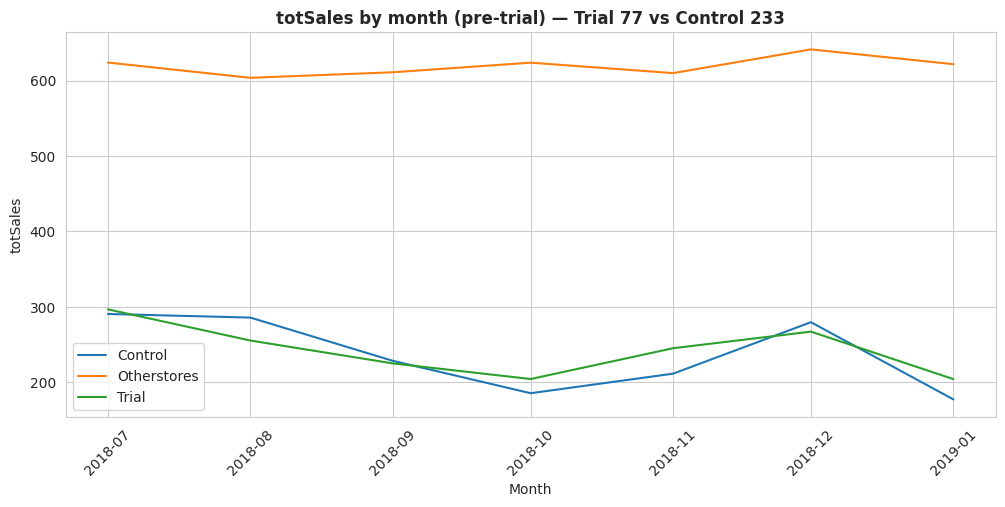

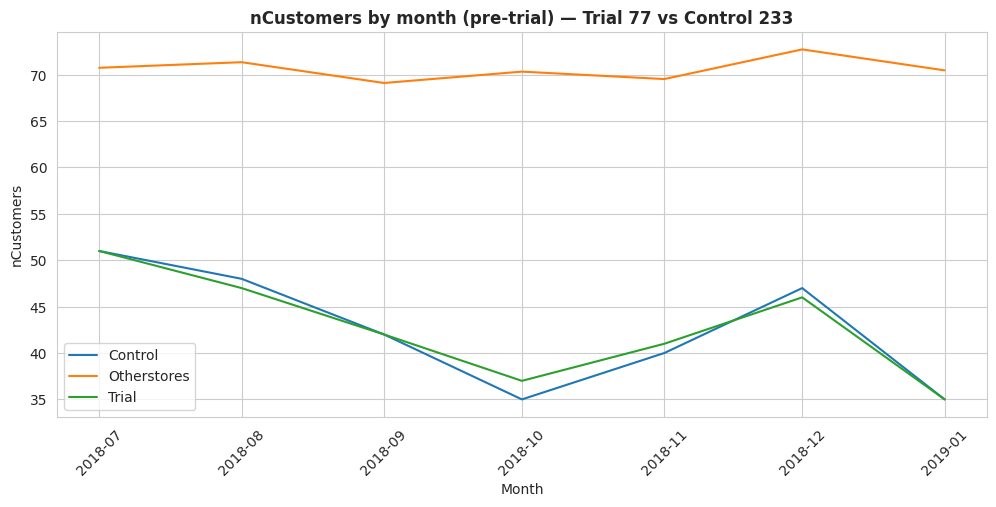

In [48]:
# 9) Visual checks for pre-trial similarity (totSales and nCustomers)
def plot_pretrial(trial_store, control_store, measure='totSales'):
    temp = measureOverTime.copy()
    # compute mean by Store_type per month (trial,control,others)
    temp['Store_type'] = np.where(temp['STORE_NBR']==trial_store, 'Trial',
                                  np.where(temp['STORE_NBR']==control_store, 'Control', 'Otherstores'))
    summary = temp.groupby(['Store_type','YEARMONTH'], observed=True)[measure].mean().reset_index()
    summary['TransactionMonth'] = pd.to_datetime(summary['YEARMONTH'].astype(str) + '01', format='%Y%m%d')
    pre = summary[summary['YEARMONTH'] < pretrial_cutoff]
    for label, grp in pre.groupby('Store_type'):
        plt.plot(grp['TransactionMonth'], grp[measure], label=label)
    plt.title(f"{measure} by month (pre-trial) — Trial {trial_store} vs Control {control_store}")
    plt.xlabel("Month")
    plt.ylabel(measure)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

plot_pretrial(trial_store, control_store, 'totSales')
plot_pretrial(trial_store, control_store, 'nCustomers')


In [54]:
# ==== PART A: SCALE CONTROL STORE SALES TO MATCH TRIAL STORE ====

trial_store = 77   # Example
# control_store = 233  # selected earlier

# 1) Total pre-trial sales for trial and control stores
trial_pre_sales = preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == trial_store),
    "totSales"
].sum()

control_pre_sales = preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == control_store),
    "totSales"
].sum()

# 2) Scaling factor
scalingFactorForControlSales = trial_pre_sales / control_pre_sales
print("Scaling Factor for SALES =", scalingFactorForControlSales)

# 3) Apply scaling to entire pre + trial period
measureOverTimeSales = measureOverTime.copy()

scaledControlSales = (
    measureOverTimeSales[measureOverTimeSales["STORE_NBR"] == control_store]
    .assign(controlSales=lambda df: df["totSales"] * scalingFactorForControlSales)
)


Scaling Factor for SALES = 1.023617303289553


In [55]:
measureOverTime.columns


Index(['STORE_NBR', 'YEARMONTH', 'totSales', 'nCustomers', 'nTxns',
       'totalChips', 'nTxnPerCust', 'nChipsPerTxn', 'avgPricePerUnit'],
      dtype='object')

In [59]:
# ----- Robust PART B: Percentage Difference between Trial and Scaled Control -----

# 1) Confirm variables exist
# (optional quick checks; you can skip if already sure)
print("Columns in measureOverTime:", measureOverTime.columns.tolist())
print("Sample YEARMONTHs:", sorted(measureOverTime['YEARMONTH'].unique())[:5])

# 2) Prepare scaledControlSales (control store sales scaled to trial pre-trial total)
control_df = measureOverTime.loc[measureOverTime["STORE_NBR"] == control_store, ["YEARMONTH", "totSales"]].copy()
# scalingFactorForControlSales must be computed previously from preTrialMeasures:
# scalingFactorForControlSales = trial_pre_sales / control_pre_sales
control_df["controlSales"] = control_df["totSales"] * scalingFactorForControlSales

# Keep only the named columns we need (avoid duplicate totSales issues)
scaledControlSales = control_df[["YEARMONTH", "controlSales"]].copy()
print("scaledControlSales sample:")
display(scaledControlSales.head())

# 3) Prepare trial_sales but rename totSales -> trialSales (to avoid collision with control column)
trial_sales = measureOverTime.loc[measureOverTime["STORE_NBR"] == trial_store, ["YEARMONTH", "totSales"]].copy()
trial_sales = trial_sales.rename(columns={"totSales": "trialSales"})
print("trial_sales sample:")
display(trial_sales.head())

# 4) Merge on YEARMONTH - now we have clean column names controlSales and trialSales
percentageDiff = pd.merge(
    scaledControlSales,
    trial_sales,
    on="YEARMONTH",
    how="inner"   # inner ensures we only compare months present in both (usually fine)
)

# 5) Compute percentage difference with safe division (avoid /0)
eps = 1e-9
percentageDiff["percentageDiff"] = (percentageDiff["controlSales"] - percentageDiff["trialSales"]).abs() / (percentageDiff["controlSales"] + eps)

# 6) Add transaction month date column for plotting & inspection
percentageDiff["TransactionMonth"] = pd.to_datetime(percentageDiff["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

print("Merged percentageDiff sample:")
display(percentageDiff.head(18))


Columns in measureOverTime: ['STORE_NBR', 'YEARMONTH', 'totSales', 'nCustomers', 'nTxns', 'totalChips', 'nTxnPerCust', 'nChipsPerTxn', 'avgPricePerUnit']
Sample YEARMONTHs: [np.int32(201807), np.int32(201808), np.int32(201809), np.int32(201810), np.int32(201811)]
scaledControlSales sample:


,YEARMONTH,controlSales
2699,201807,297.565550
2700,201808,292.652187
2701,201809,233.998916
2702,201810,190.085733
2703,201811,216.597421


trial_sales sample:


,YEARMONTH,trialSales
880,201807,296.8
881,201808,255.5
882,201809,225.2
883,201810,204.5
884,201811,245.3


Merged percentageDiff sample:


,YEARMONTH,controlSales,trialSales,percentageDiff,TransactionMonth
0,201807,297.565550,296.8,0.002573,2018-07-01
1,201808,292.652187,255.5,0.126950,2018-08-01
2,201809,233.998916,225.2,0.037602,2018-09-01
3,201810,190.085733,204.5,0.075830,2018-10-01
4,201811,216.597421,245.3,0.132516,2018-11-01
5,201812,286.408121,267.3,0.066716,2018-12-01
6,201901,181.692071,204.4,0.124980,2019-01-01
7,201902,249.762622,235.0,0.059107,2019-02-01
8,201903,203.802205,278.5,0.366521,2019-03-01
9,201904,162.345704,263.5,0.623080,2019-04-01


In [61]:
# ==== PART C: Standard Deviation of pre-trial percentage differences ====

pre_period = percentageDiff[percentageDiff["YEARMONTH"] < pretrial_cutoff]
stdDev = pre_period["percentageDiff"].std()
degreesOfFreedom = len(pre_period) - 1   # same logic as R = 7

print("stdDev =", stdDev, "| df =", degreesOfFreedom)

# 95th percentile of t-distribution
from scipy.stats import t
t_critical = t.ppf(0.95, df=degreesOfFreedom)
print("95% Threshold t_value =", t_critical)

# Compute t-value for each month
percentageDiff["tValue"] = percentageDiff["percentageDiff"] / stdDev

# Extract only trial period Feb–April 2019 (201902–201904)
trial_window = percentageDiff[
    (percentageDiff["YEARMONTH"] > 201901) &
    (percentageDiff["YEARMONTH"] < 201905)
][["YEARMONTH", "tValue"]]

display(trial_window)


stdDev = 0.04994076264119642 | df = 6
95% Threshold t_value = 1.9431802805153022


,YEARMONTH,tValue
7,201902,1.183534
8,201903,7.339116
9,201904,12.476373


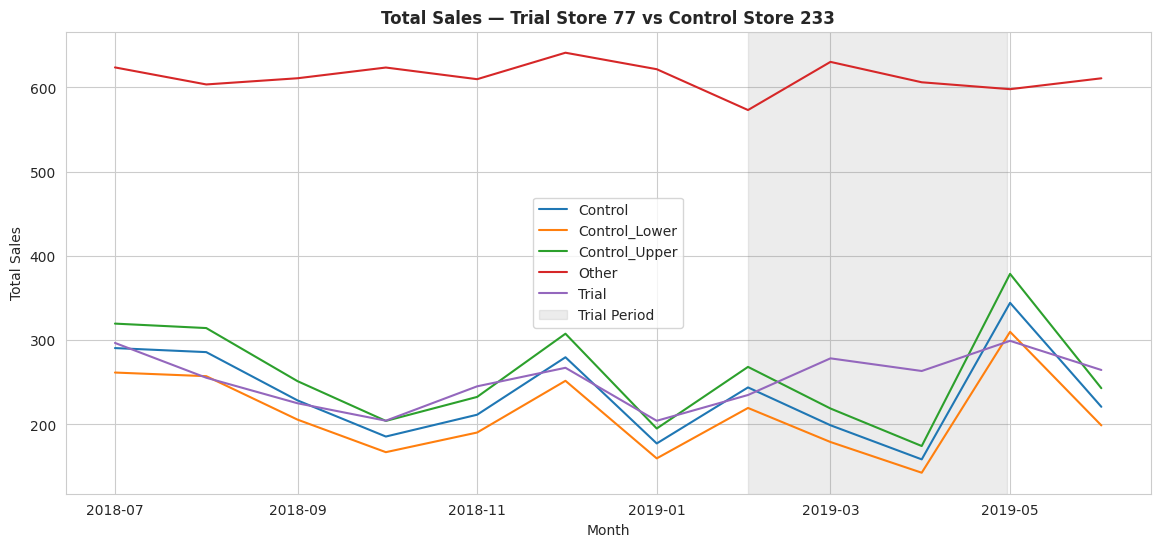

In [62]:
# ==== PART D: Plot Trial vs Control with Confidence Bands ====

import matplotlib.pyplot as plt

# Prepare data
pastSales = measureOverTimeSales.copy()
pastSales["Store_type"] = np.where(
    pastSales["STORE_NBR"] == trial_store, "Trial",
    np.where(pastSales["STORE_NBR"] == control_store, "Control", "Other")
)

# calculate monthly averages
pastSales = pastSales.groupby(["Store_type", "YEARMONTH"], as_index=False)["totSales"].mean()

# Add date column
pastSales["TransactionMonth"] = pd.to_datetime(
    pastSales["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# Confidence intervals for control store
control_df = pastSales[pastSales["Store_type"] == "Control"].copy()
control_df95 = control_df.copy()
control_df5 = control_df.copy()

control_df95["Store_type"] = "Control_Upper"
control_df95["totSales"] = control_df["totSales"] * (1 + stdDev * 2)

control_df5["Store_type"] = "Control_Lower"
control_df5["totSales"] = control_df["totSales"] * (1 - stdDev * 2)

# Combine all
plot_df = pd.concat([pastSales, control_df95, control_df5])

# Plot
plt.figure(figsize=(14,6))

for label, grp in plot_df.groupby("Store_type"):
    plt.plot(grp["TransactionMonth"], grp["totSales"], label=label)

plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"),
            color='grey', alpha=0.15, label="Trial Period")

plt.title(f"Total Sales — Trial Store {trial_store} vs Control Store {control_store}")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.legend()
plt.show()


In [64]:
# ==== PART E: CUSTOMER LEVEL ANALYSIS ====

# 1) Scaling factor for customers
trial_pre_cust = preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == trial_store),
    "nCustomers"
].sum()

control_pre_cust = preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == control_store),
    "nCustomers"
].sum()

scalingFactorForControlCust = trial_pre_cust / control_pre_cust
print("Scaling Factor for CUSTOMERS =", scalingFactorForControlCust)

# 2) Apply scaling
measureOverTimeCusts = measureOverTime.copy()
scaledControlCust = (
    measureOverTimeCusts[measureOverTimeCusts["STORE_NBR"] == control_store]
    .assign(controlCustomers=lambda df: df["nCustomers"] * scalingFactorForControlCust)
)

# 3) Percentage difference
trial_cust = measureOverTimeCusts[
    measureOverTimeCusts["STORE_NBR"] == trial_store
][["YEARMONTH", "nCustomers"]]

percentageDiffCust = scaledControlCust.merge(trial_cust, on="YEARMONTH")
percentageDiffCust["percentageDiff"] = (
    (percentageDiffCust["controlCustomers"] - percentageDiffCust["nCustomers"]).abs()
    / percentageDiffCust["controlCustomers"]
)

# 4) StdDev & T-values
pre_cust = percentageDiffCust[percentageDiffCust["YEARMONTH"] < pretrial_cutoff]
stdDev_cust = pre_cust["percentageDiff"].std()
degreesOfFreedomCust = len(pre_cust) - 1

t_critical = t.ppf(0.95, degreesOfFreedomCust)

percentageDiffCust["tValue"] = percentageDiffCust["percentageDiff"] / stdDev_cust

display(percentageDiffCust.head())


Scaling Factor for CUSTOMERS = 1.0033557046979866


KeyError: 'nCustomers'

In [65]:
print(measureOverTime.columns)


Index(['STORE_NBR', 'YEARMONTH', 'totSales', 'nCustomers', 'nTxns',
       'totalChips', 'nTxnPerCust', 'nChipsPerTxn', 'avgPricePerUnit'],
      dtype='object')


In [66]:
# --- Detect customer column dynamically ---
customer_col = None
for col in measureOverTime.columns:
    if "cust" in col.lower():
        customer_col = col
        break

print("Customer column detected =", customer_col)

# --- PART E: CUSTOMER LEVEL ANALYSIS ---

# 1) Scaling factor
trial_pre_cust = preTrialMeasures.loc[
    preTrialMeasures["STORE_NBR"] == trial_store, customer_col
].sum()

control_pre_cust = preTrialMeasures.loc[
    preTrialMeasures["STORE_NBR"] == control_store, customer_col
].sum()

scalingFactorForControlCust = trial_pre_cust / control_pre_cust
print("Scaling Factor for CUSTOMERS =", scalingFactorForControlCust)

# 2) Apply scaling
measureOverTimeCusts = measureOverTime.copy()
scaledControlCust = (
    measureOverTimeCusts[measureOverTimeCusts["STORE_NBR"] == control_store]
    .assign(controlCustomers=lambda df: df[customer_col] * scalingFactorForControlCust)
    [["YEARMONTH", "controlCustomers"]]   # keep only relevant columns
)

# 3) Percentage difference
trial_cust = measureOverTimeCusts[
    measureOverTimeCusts["STORE_NBR"] == trial_store
][["YEARMONTH", customer_col]]

percentageDiffCust = scaledControlCust.merge(trial_cust, on="YEARMONTH")
percentageDiffCust["percentageDiff"] = (
    (percentageDiffCust["controlCustomers"] - percentageDiffCust[customer_col]).abs()
    / percentageDiffCust["controlCustomers"]
)

# 4) Std deviation & t-values
pre_cust = percentageDiffCust[percentageDiffCust["YEARMONTH"] < pretrial_cutoff]
stdDev_cust = pre_cust["percentageDiff"].std()
degreesOfFreedomCust = len(pre_cust) - 1

from scipy.stats import t
t_critical = t.ppf(0.95, df=degreesOfFreedomCust)

percentageDiffCust["tValue"] = percentageDiffCust["percentageDiff"] / stdDev_cust

display(percentageDiffCust.head())
print("t-critical =", t_critical)


Customer column detected = nCustomers
Scaling Factor for CUSTOMERS = 1.0033557046979866


,YEARMONTH,controlCustomers,nCustomers,percentageDiff,tValue
0,201807,51.171141,51,0.003344,0.183352
1,201808,48.161074,47,0.024108,1.321664
2,201809,42.140940,42,0.003344,0.183352
3,201810,35.117450,37,0.053607,2.938874
4,201811,40.134228,41,0.021572,1.182622


t-critical = 1.9431802805153022


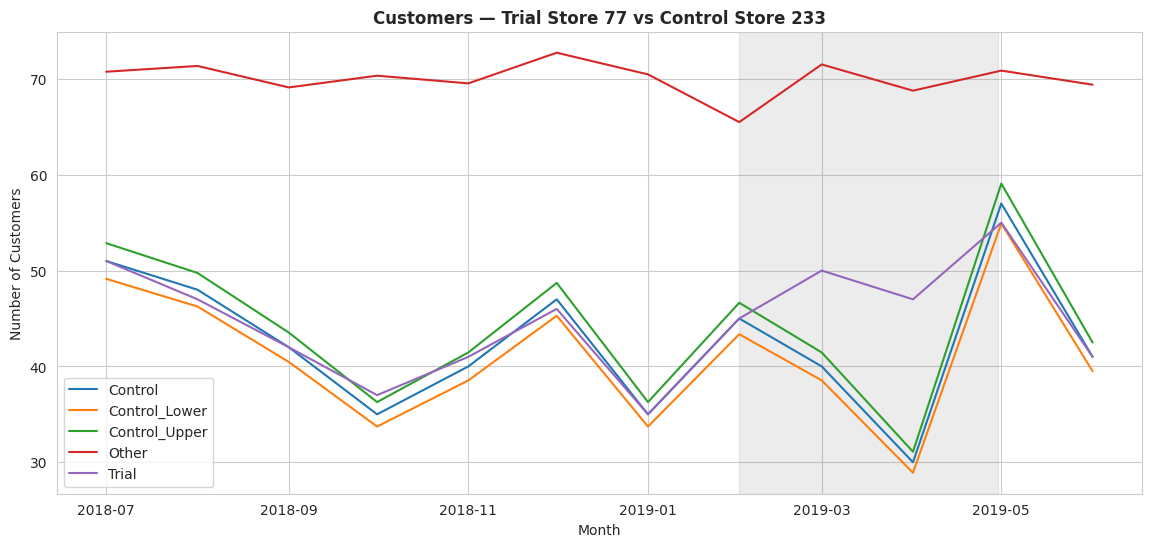

In [67]:
# ==== PART F: Plot Customers ====

pastCust = measureOverTimeCusts.copy()
pastCust["Store_type"] = np.where(
    pastCust["STORE_NBR"] == trial_store, "Trial",
    np.where(pastCust["STORE_NBR"] == control_store, "Control", "Other")
)

pastCust = pastCust.groupby(["Store_type", "YEARMONTH"], as_index=False)["nCustomers"].mean()
pastCust["TransactionMonth"] = pd.to_datetime(
    pastCust["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# Confidence intervals
control_cust = pastCust[pastCust["Store_type"] == "Control"].copy()
control95 = control_cust.copy()
control5 = control_cust.copy()

control95["Store_type"] = "Control_Upper"
control95["nCustomers"] = control_cust["nCustomers"] * (1 + stdDev_cust * 2)

control5["Store_type"] = "Control_Lower"
control5["nCustomers"] = control_cust["nCustomers"] * (1 - stdDev_cust * 2)

plot_df2 = pd.concat([pastCust, control95, control5])

plt.figure(figsize=(14,6))

for label, grp in plot_df2.groupby("Store_type"):
    plt.plot(grp["TransactionMonth"], grp["nCustomers"], label=label)

plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"),
            color='grey', alpha=0.15)

plt.title(f"Customers — Trial Store {trial_store} vs Control Store {control_store}")
plt.ylabel("Number of Customers")
plt.xlabel("Month")
plt.legend()
plt.show()



--- Running trial assessment for store 88 ---
Top candidates (first 6):


,Store1,Store2,scoreNSales,scoreNCust,finalControlScore
0,88,88,1.000000,1.000000,1.000000
1,88,237,0.632277,0.967456,0.799867
2,88,178,0.713855,0.880310,0.797083
3,88,69,0.578920,0.842388,0.710654
4,88,113,0.589285,0.823346,0.706315
5,88,201,0.682885,0.715939,0.699412


Chosen control store: 237


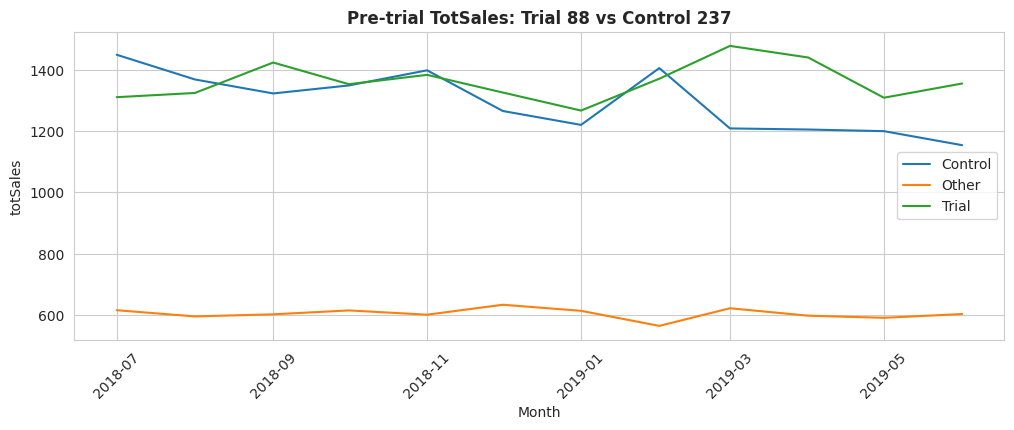

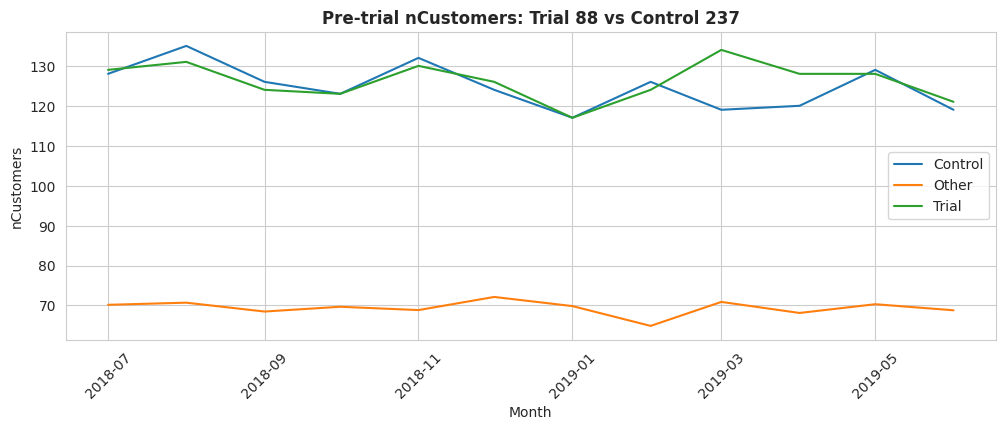

scalingFactorForControlSales: 1.001558330664959
stdDev (sales): 0.03346786730305517 | df: 6 | t_critical (95%) 1.9431802805153022

Sales trial months t-values (YEARMONTH, tValue):


,YEARMONTH,TransactionMonth,percentageDiff,tValue
7,201902,2019-02-01,0.026147,0.781270
8,201903,2019-03-01,0.220743,6.595668
9,201904,2019-04-01,0.193060,5.768527


/tmp/ipython-input-3462127493.py:128: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  control_mean = control_mean.reindex(sorted(pastSales['YEARMONTH'].unique())).fillna(method='ffill')


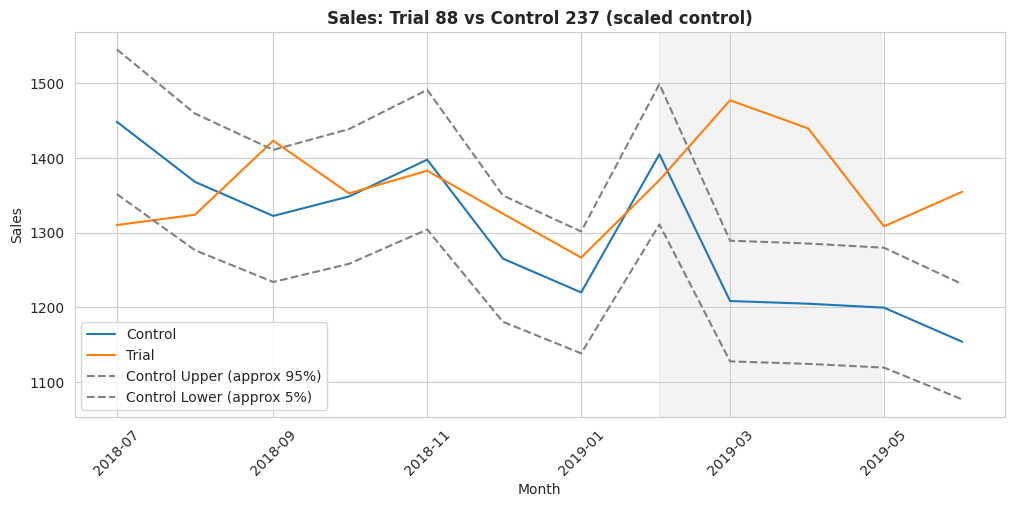

scalingFactorForControlCust: 0.9943502824858758
stdDev (customers): 0.007410244352019086 | df: 6 | t_critical (95%) 1.9431802805153022

Customer trial months t-values (YEARMONTH, tValue):


,YEARMONTH,TransactionMonth,percentageDiff,tValue
7,201902,2019-02-01,0.010281,1.387455
8,201903,2019-03-01,0.132448,17.873691
9,201904,2019-04-01,0.072727,9.814422


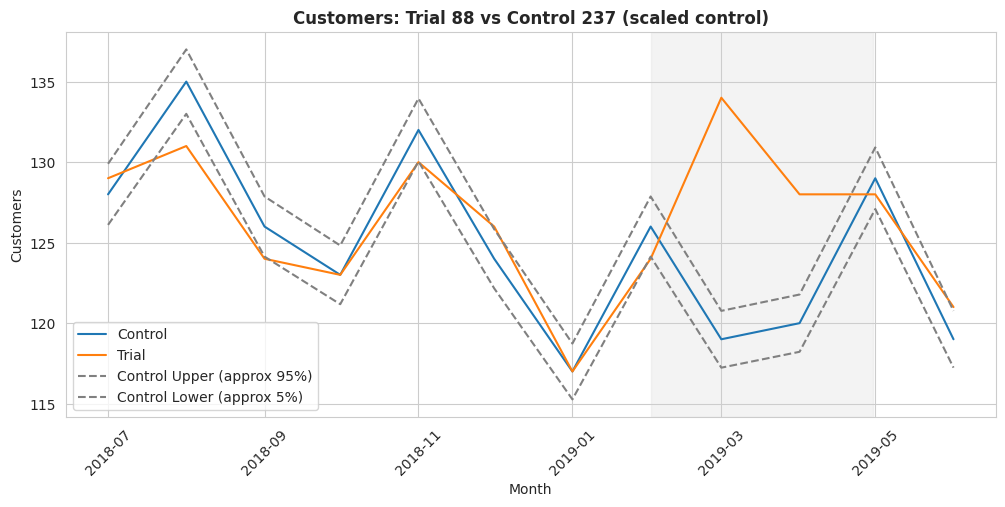

In [68]:
# ---------- Final Task 2: Trial assessment for a trial store (example: 88) ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# Ensure these exist: measureOverTime, preTrialMeasures, calculate_correlation, calculate_magnitude_distance
# If not, you must create measureOverTime exactly as in earlier steps:
# measureOverTime columns expected: ['STORE_NBR','YEARMONTH','totSales','nCustomers', ...]

# Defensive column detection (in case names slightly differ)
cols = measureOverTime.columns.tolist()
if 'totSales' not in cols:
    raise KeyError("Expected column 'totSales' in measureOverTime. Found: " + ", ".join(cols))
if 'nCustomers' not in cols:
    raise KeyError("Expected column 'nCustomers' in measureOverTime. Found: " + ", ".join(cols))

def pick_control_store(preTrialMeasures, trial_store, corr_weight=0.5, min_overlap=3):
    # compute correlation and magnitude for sales and customers
    corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store, min_overlap=min_overlap)
    corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store, min_overlap=min_overlap)
    mag_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)
    mag_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

    # merge and compute driver scores
    score_nSales = corr_nSales.merge(mag_nSales, on=['Store1','Store2'], how='left')
    score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)

    score_nCustomers = corr_nCustomers.merge(mag_nCustomers, on=['Store1','Store2'], how='left')
    score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)

    # combine
    score_Control = score_nSales[['Store1','Store2','scoreNSales']].merge(score_nCustomers[['Store1','Store2','scoreNCust']],
                                                                            on=['Store1','Store2'], how='left')
    score_Control['finalControlScore'] = 0.5 * score_Control['scoreNSales'] + 0.5 * score_Control['scoreNCust']

    # rank and pick top (excluding the trial store itself)
    ranked = score_Control[score_Control['Store1'] == trial_store].sort_values('finalControlScore', ascending=False).reset_index(drop=True)
    # If the top is the store itself, choose next best
    for i, row in ranked.iterrows():
        if int(row['Store2']) != int(trial_store):
            return int(row['Store2']), ranked
    # fallback
    return None, ranked

def run_trial_assessment(trial_store, pretrial_cutoff=201902, plot=True):
    print(f"\n--- Running trial assessment for store {trial_store} ---")
    control_store, ranked = pick_control_store(preTrialMeasures, trial_store)
    print("Top candidates (first 6):")
    display(ranked.head(6))
    print("Chosen control store:", control_store)
    if control_store is None:
        raise RuntimeError("No control store found")

    # VISUAL CHECK: pre-trial similarity (sales and customers)
    # sales
    pastSales = measureOverTime.copy()
    pastSales['Store_type'] = np.where(pastSales['STORE_NBR']==trial_store, 'Trial',
                                      np.where(pastSales['STORE_NBR']==control_store, 'Control', 'Other'))
    pastSales = pastSales.groupby(['Store_type','YEARMONTH'], observed=True)['totSales'].mean().reset_index()
    pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

    if plot:
        plt.figure(figsize=(12,4))
        for label, grp in pastSales.groupby('Store_type'):
            plt.plot(grp['TransactionMonth'], grp['totSales'], label=label)
        plt.title(f"Pre-trial TotSales: Trial {trial_store} vs Control {control_store}")
        plt.xlabel("Month"); plt.ylabel("totSales"); plt.legend(); plt.xticks(rotation=45)
        plt.show()

    # customers
    pastCust = measureOverTime.copy()
    pastCust['Store_type'] = np.where(pastCust['STORE_NBR']==trial_store, 'Trial',
                                      np.where(pastCust['STORE_NBR']==control_store, 'Control', 'Other'))
    pastCust = pastCust.groupby(['Store_type','YEARMONTH'], observed=True)['nCustomers'].mean().reset_index()
    pastCust['TransactionMonth'] = pd.to_datetime(pastCust['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

    if plot:
        plt.figure(figsize=(12,4))
        for label, grp in pastCust.groupby('Store_type'):
            plt.plot(grp['TransactionMonth'], grp['nCustomers'], label=label)
        plt.title(f"Pre-trial nCustomers: Trial {trial_store} vs Control {control_store}")
        plt.xlabel("Month"); plt.ylabel("nCustomers"); plt.legend(); plt.xticks(rotation=45)
        plt.show()

    # SCALE control sales to trial pre-trial level
    trial_pre_sales = preTrialMeasures.loc[preTrialMeasures['STORE_NBR']==trial_store,'totSales'].sum()
    control_pre_sales = preTrialMeasures.loc[preTrialMeasures['STORE_NBR']==control_store,'totSales'].sum()
    scalingFactorForControlSales = trial_pre_sales / control_pre_sales
    print("scalingFactorForControlSales:", scalingFactorForControlSales)

    control_df = measureOverTime.loc[measureOverTime['STORE_NBR']==control_store, ['YEARMONTH','totSales']].copy()
    control_df['controlSales'] = control_df['totSales'] * scalingFactorForControlSales
    control_df = control_df[['YEARMONTH','controlSales']]

    trial_df = measureOverTime.loc[measureOverTime['STORE_NBR']==trial_store, ['YEARMONTH','totSales']].copy()
    trial_df = trial_df.rename(columns={'totSales':'trialSales'})

    merged = pd.merge(control_df, trial_df, on='YEARMONTH', how='inner')
    merged['percentageDiff'] = (merged['controlSales'] - merged['trialSales']).abs() / (merged['controlSales'] + 1e-9)
    merged['TransactionMonth'] = pd.to_datetime(merged['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

    # standard deviation from pre-trial months
    pre_period = merged[merged['YEARMONTH'] < pretrial_cutoff]
    stdDev = pre_period['percentageDiff'].std()
    df = max(len(pre_period)-1, 1)
    t_critical = t.ppf(0.95, df=df)
    print("stdDev (sales):", stdDev, "| df:", df, "| t_critical (95%)", t_critical)

    # t-values for trial months (use Feb-Apr match R, but can switch to Mar-Jun if your data has these)
    trial_window = merged[(merged['YEARMONTH'] > 201901) & (merged['YEARMONTH'] < 201905)].copy()
    trial_window['tValue'] = trial_window['percentageDiff'] / (stdDev + 1e-9)
    print("\nSales trial months t-values (YEARMONTH, tValue):")
    display(trial_window[['YEARMONTH','TransactionMonth','percentageDiff','tValue']])

    # plot sales with control bands
    # build aggregated monthly series for trial & control
    plot_sales = pd.concat([
        pastSales[pastSales['Store_type'].isin(['Trial','Control'])],
        pd.DataFrame({
            'Store_type': ['Control_Upper']*len(control_df['YEARMONTH']),
            'YEARMONTH': control_df['YEARMONTH'],
            'totSales': np.nan
        })
    ], ignore_index=True)
    # create control bounds per month
    control_mean = pastSales[pastSales['Store_type']=='Control'][['YEARMONTH','totSales']].set_index('YEARMONTH')
    control_mean = control_mean.reindex(sorted(pastSales['YEARMONTH'].unique())).fillna(method='ffill')
    # build control bound arrays using stdDev
    cn = control_mean.reset_index()
    cn['upper'] = cn['totSales'] * (1 + stdDev*2)
    cn['lower'] = cn['totSales'] * (1 - stdDev*2)
    cn['TransactionMonth'] = pd.to_datetime(cn['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

    # real plotting
    plt.figure(figsize=(12,5))
    # plot trial and control mean lines
    for label, grp in pastSales[pastSales['Store_type'].isin(['Trial','Control'])].groupby('Store_type'):
        plt.plot(grp['TransactionMonth'], grp['totSales'], label=label)
    plt.plot(cn['TransactionMonth'], cn['upper'], linestyle='--', color='grey', label='Control Upper (approx 95%)')
    plt.plot(cn['TransactionMonth'], cn['lower'], linestyle='--', color='grey', label='Control Lower (approx 5%)')
    plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='lightgrey', alpha=0.25)
    plt.title(f"Sales: Trial {trial_store} vs Control {control_store} (scaled control)")
    plt.xlabel("Month"); plt.ylabel("Sales"); plt.legend(); plt.xticks(rotation=45)
    plt.show()

    # ---------------------- customers -------------------------
    # scale control customers
    trial_pre_cust = preTrialMeasures.loc[preTrialMeasures['STORE_NBR']==trial_store,'nCustomers'].sum()
    control_pre_cust = preTrialMeasures.loc[preTrialMeasures['STORE_NBR']==control_store,'nCustomers'].sum()
    scalingFactorForControlCust = trial_pre_cust / control_pre_cust
    print("scalingFactorForControlCust:", scalingFactorForControlCust)

    control_cust = measureOverTime.loc[measureOverTime['STORE_NBR']==control_store, ['YEARMONTH','nCustomers']].copy()
    control_cust['controlCustomers'] = control_cust['nCustomers'] * scalingFactorForControlCust
    trial_cust = measureOverTime.loc[measureOverTime['STORE_NBR']==trial_store, ['YEARMONTH','nCustomers']].copy()
    trial_cust = trial_cust.rename(columns={'nCustomers':'trialCustomers'})

    merged_cust = pd.merge(control_cust[['YEARMONTH','controlCustomers']], trial_cust, on='YEARMONTH', how='inner')
    merged_cust['percentageDiff'] = (merged_cust['controlCustomers'] - merged_cust['trialCustomers']).abs() / (merged_cust['controlCustomers'] + 1e-9)
    merged_cust['TransactionMonth'] = pd.to_datetime(merged_cust['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

    # std dev and t-values for customers
    pre_cust = merged_cust[merged_cust['YEARMONTH'] < pretrial_cutoff]
    stdDev_cust = pre_cust['percentageDiff'].std()
    df_cust = max(len(pre_cust)-1, 1)
    t_critical_cust = t.ppf(0.95, df=df_cust)
    print("stdDev (customers):", stdDev_cust, "| df:", df_cust, "| t_critical (95%)", t_critical_cust)

    trial_window_cust = merged_cust[(merged_cust['YEARMONTH'] > 201901) & (merged_cust['YEARMONTH'] < 201905)].copy()
    trial_window_cust['tValue'] = trial_window_cust['percentageDiff'] / (stdDev_cust + 1e-9)
    print("\nCustomer trial months t-values (YEARMONTH, tValue):")
    display(trial_window_cust[['YEARMONTH','TransactionMonth','percentageDiff','tValue']])

    # plot customers with bands
    pastCust_plot = pastCust[pastCust['Store_type'].isin(['Trial','Control'])].copy()
    cn2 = pastCust_plot[pastCust_plot['Store_type']=='Control'][['YEARMONTH','nCustomers']].set_index('YEARMONTH').reset_index()
    cn2['upper'] = cn2['nCustomers'] * (1 + stdDev_cust*2)
    cn2['lower'] = cn2['nCustomers'] * (1 - stdDev_cust*2)
    cn2['TransactionMonth'] = pd.to_datetime(cn2['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

    plt.figure(figsize=(12,5))
    for label, grp in pastCust_plot.groupby('Store_type'):
        plt.plot(grp['TransactionMonth'], grp['nCustomers'], label=label)
    plt.plot(cn2['TransactionMonth'], cn2['upper'], linestyle='--', color='grey', label='Control Upper (approx 95%)')
    plt.plot(cn2['TransactionMonth'], cn2['lower'], linestyle='--', color='grey', label='Control Lower (approx 5%)')
    plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='lightgrey', alpha=0.25)
    plt.title(f"Customers: Trial {trial_store} vs Control {control_store} (scaled control)")
    plt.xlabel("Month"); plt.ylabel("Customers"); plt.legend(); plt.xticks(rotation=45)
    plt.show()

    # Return key results for programmatic checks
    out = {
        'trial_store': trial_store,
        'control_store': control_store,
        'sales_stdDev': stdDev,
        'sales_t_values': trial_window[['YEARMONTH','percentageDiff','tValue']],
        'cust_stdDev': stdDev_cust,
        'cust_t_values': trial_window_cust[['YEARMONTH','percentageDiff','tValue']]
    }
    return out

# Run for trial store 88
results_88 = run_trial_assessment(88)
